In [1]:
import pandas as pd
import json
import requests
from collections import Counter
from pprint import pprint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# set the default plot size
pylab.rcParams['figure.figsize'] = (12, 6)

In [4]:
# load player prospect data
players = pd.read_csv('2018_mlb_prospect_players.csv')

In [5]:
# inspect the DataFrame
players.head()

,player_first_name,player_id,player_last_name,position,preseason100,preseason20,prospect_year,rank,team_file_code
0,Khalil,666137,Lee,OF,NaN,1.0,2018,1,KC
1,Nick,668472,Pratto,1B,NaN,2.0,2018,2,KC
2,Seuly,665890,Matias,OF,NaN,3.0,2018,3,KC
3,MJ,669004,Melendez,C,NaN,4.0,2018,4,KC
4,Michael,669377,Gigliotti,OF,NaN,5.0,2018,5,KC


In [6]:
# are some players listed multiple times?
players['player_id'].value_counts()[:5]

660271    4
656713    4
608331    3
608348    3
642715    3
Name: player_id, dtype: int64

In [7]:
# lets look at these players that are listed multiple times
players[players['player_id'] == '656713']

,player_first_name,player_id,player_last_name,position,preseason100,preseason20,prospect_year,rank,team_file_code
154,Brendan,656713,McKay,1B/LHP,25,NaN,2018,5,TB
382,Brendan,656713,McKay,1B/LHP,25,3.0,2018,3,TB
524,Brendan,656713,McKay,1B/LHP,25,3.0,2018,25,TB
630,Brendan,656713,McKay,1B/LHP,NaN,NaN,2018,1,TB


In [8]:
# grab the unique player_id from the DataFrame
player_ids = players['player_id'].unique().tolist()

In [9]:
# how many unique players are there?
len(player_ids)

950

In [10]:
# get data for each player
responses = []
for i in player_ids:
    r = requests.get("http://m.mlb.com/gen/players/prospects/2018/{}.json".format(i))
    responses.append(r)

In [11]:
# what is the status of the responses received
Counter([i.status_code for i in responses])

Counter({200: 950})

In [12]:
# write JSON data
with open('2018_mlb_prospect_player_data.json', 'w') as f:
    json.dump(r.text, f)

In [13]:
# read in JSON data
data = json.loads(json.load(open('2018_mlb_prospect_player_data.json')))

In [14]:
# extract the content from each response
data = []
for line in responses:
    line = json.loads(line.text)
    data.append(line['prospect_player'])

In [15]:
# look at the dictionary keys in the first record
data[0].keys()

dict_keys(['bats', 'eta', 'preseason100', 'positions', 'year', 'school', 'height', 'player_id', 'player_last_name', 'twitter', 'preseason20', 'weight', 'birthdate', 'player_first_name', 'content', 'team_file_code', 'drafted', 'thrw', 'signed'])

In [16]:
# inspect the first record
pprint(data[0])

{'bats': '',
 'birthdate': '',
 'content': {'default': '<p><b>Scouting grades:</b> Hit: 50 | Power: 55 | Run: '
                        '55 | Arm: 60 | Field: 55 | Overall: 50\n'
                        '<p>Though he had a low-90s fastball and a promising '
                        'slider, intriguing several clubs as a left-handed '
                        'pitching prospect, the Royals liked his multitool '
                        'ability more. They made him a full-time outfielder '
                        'after signing him for an over-slot $750,000 as a '
                        'third-rounder in 2016, and they have no reason to '
                        'regret that decision. He led the Rookie-level Arizona '
                        'League in runs (43), triples (six) and total bases '
                        '(88) during his pro debut, then ranked second in '
                        'homers (17) and third in walks (65) in the low Class '
                        'A South Atlantic 

In [17]:
# iterate over data and clean up the content
for line in data:
    
    # remove newline delimiter
    bio = line['content']['default'].replace('\n', '').strip()
    
    # conform scouting grades
    variations = ['<b>Scouting grades:</b>', 
                  '<b>Scouting grades</b>:', 
                  '<b>Scouting grades</b>:', 
                  '<b>Scouting Grades:</b>',
                  '<p>Scouting Grades:</b>',
                  '<p><b>Scouting Grades:</b> Scouting Grades:']
    
    for i in variations:
        if bio.startswith(i):
            bio = bio.replace(i, 'Scouting Grades')
    
    # split the bio on paragraph tag
    bio = bio.split('<p>')
    
    # create a new key to hold bio
    line['bio'] = bio

In [18]:
# inspect the new bio 
pprint(data[0]['bio'])

['',
 '<b>Scouting grades:</b> Hit: 50 | Power: 55 | Run: 55 | Arm: 60 | Field: 55 '
 '| Overall: 50',
 'Though he had a low-90s fastball and a promising slider, intriguing several '
 'clubs as a left-handed pitching prospect, the Royals liked his multitool '
 'ability more. They made him a full-time outfielder after signing him for an '
 'over-slot $750,000 as a third-rounder in 2016, and they have no reason to '
 'regret that decision. He led the Rookie-level Arizona League in runs (43), '
 'triples (six) and total bases (88) during his pro debut, then ranked second '
 'in homers (17) and third in walks (65) in the low Class A South Atlantic '
 'League at age 19 last year.',
 'If he can make some adjustments at the plate, Lee could have solid or better '
 "tools across the board. Though he's not physically imposing at 5-foot-10, "
 'the bat speed and loft in his left-handed swing give him surprising raw '
 'power. He has some feel to hit and a willingness to work counts, though he '


In [19]:
# iterate over data and extract scouting grades into new keys
for line in data:
    
    # create an empty container to hold non-scouting grades
    bio = []
    
    # iterate over the bio key specifically
    for item in line['bio']:
    
        # get the line that starts with scouting grades
        if item.startswith('Scouting Grades'):

            # remove the beginning of the sententce
            grades = item.replace('Scouting Grades', '')
            
            # address edge case with missing colon
            grades = grades.replace('Arm ', 'Arm:')
            grades = grades.replace('Control ', 'Control:')

            # split in seperate metrics
            metrics = grades.split('|')

            # iterate over the metrics
            for i in metrics:

                # seperate the metric from the value
                value = i.split(':')

                # add metrics and values as new keys/values
                line[value[0].strip()] = value[1].strip()
                
        # if it's not a scouting grade...
        else:
            
            # add to bio
            bio.append(item)
            
    # join the bio text into one string
    line['bio'] = ''.join(bio)

In [20]:
# inspect one record
pprint(data[0])

{'bats': '',
 'bio': '<b>Scouting grades:</b> Hit: 50 | Power: 55 | Run: 55 | Arm: 60 | '
        'Field: 55 | Overall: 50Though he had a low-90s fastball and a '
        'promising slider, intriguing several clubs as a left-handed pitching '
        'prospect, the Royals liked his multitool ability more. They made him '
        'a full-time outfielder after signing him for an over-slot $750,000 as '
        'a third-rounder in 2016, and they have no reason to regret that '
        'decision. He led the Rookie-level Arizona League in runs (43), '
        'triples (six) and total bases (88) during his pro debut, then ranked '
        'second in homers (17) and third in walks (65) in the low Class A '
        'South Atlantic League at age 19 last year.If he can make some '
        'adjustments at the plate, Lee could have solid or better tools across '
        "the board. Though he's not physically imposing at 5-foot-10, the bat "
        'speed and loft in his left-handed swing give him

In [21]:
# iterate over data convert values to integers where possible
for line in data:
    for key in line:
        try:
            line[key] = int(line[key])
        except:
            pass

In [22]:
# load data into a DataFrame
df = pd.DataFrame(data)

In [23]:
# convert column names to lowercase
df.columns = df.columns.str.lower()

In [24]:
# inspect the DataFrame
df.head()

,arm,changeup,control,curve,curveball,cutter,cuverball,defense,fastball,field,...,positions,preseason100,preseason20,school,signed,team_file_code,thrw,twitter,weight,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,OF,,1,,,KC,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1B,,2,,,KC,,n_pratto,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,OF,,3,,"July 2, 2015 - KC",KC,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,C,,4,,,KC,,mjmelendez7,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,OF,,5,,,KC,,MikeGigsss,,


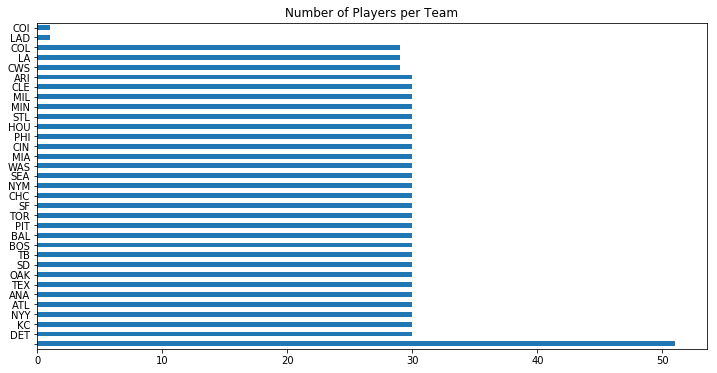

In [25]:
# plot the number of players per team
df['team_file_code'].value_counts().plot('barh', title='Number of Players per Team')

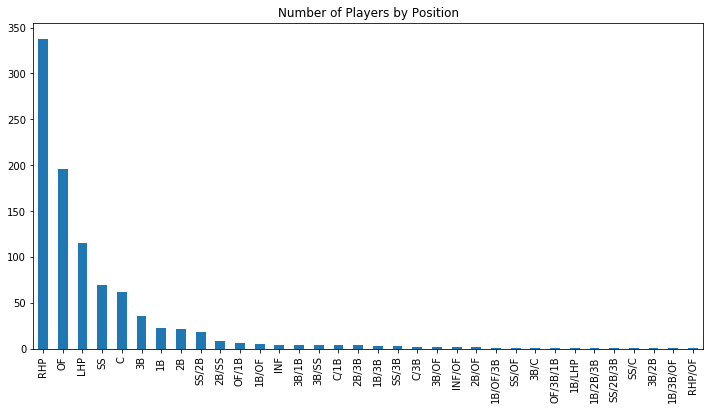

In [26]:
# count the number players by positions
df['positions'].value_counts().plot('bar', title='Number of Players by Position')

[]

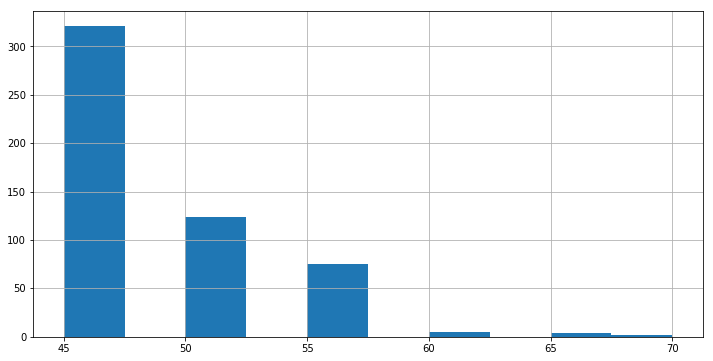

In [27]:
# calculate the average overall score
df['overall'].hist().plot()

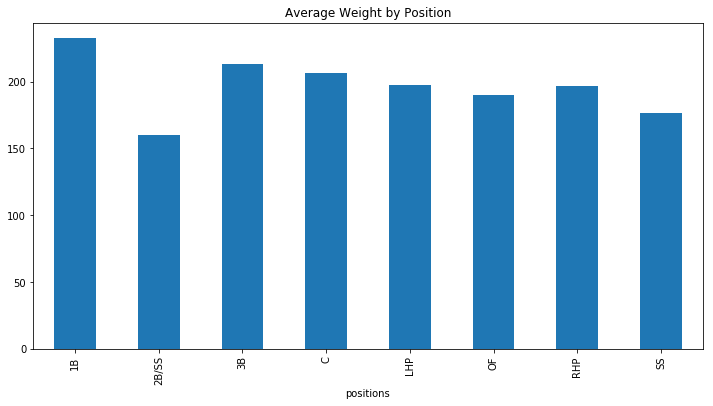

In [28]:
# subset DataFarme to positions and weight
position_weight = df[['positions', 'weight']]

# convert missing to NA
position_weight = position_weight.replace(r'\s+',np.nan,regex=True).replace('',np.nan)

# convert weight to integer
position_weight['weight'] = pd.to_numeric(position_weight['weight'])

# drop records with missing data
position_weight = position_weight.dropna(subset=['positions', 'weight'])

# group by position and calculate the average weight
position_weight.groupby('positions')['weight'].mean().plot('bar', title='Average Weight by Position')

In [29]:
# write the dataframe to CSV
df.to_csv("2018_mlb_prospect_player_data.csv", index=False)